In [1]:
import pandas as pd
import numpy as np
import joblib
import time
import socket
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import notebook

%matplotlib inline

In [2]:
from sklearn.metrics import ndcg_score

def precision(actual, predicted, k):
    act_set = set(actual[:k])
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    
    return result
    
def evaluate_ranking(pred, test, k=5, exponential_scaling=False):    
    ndcg = []
    prec  = []
    for i, pred_row in pred.iterrows():
        test_row = test.loc[i]
        shared_drugs = list(set(pred_row.dropna().index) & set(test_row.dropna().index))
        test_row = test_row[shared_drugs]
        pred_row = pred_row[shared_drugs]
        
        pred_order = pred_row.sort_values().index.tolist()
        test_order = test_row.sort_values().index.tolist()
                        
        if len(shared_drugs) > 1:
            ndcg.append(ndcg_score([test_row.values], [pred_row.values], k=k))
            
        prec.append(precision(test_order, pred_order, k=k))
        
        
    return (np.mean(prec), np.mean(ndcg))

def transform_negative_4_ndcg(df):
    min_val = df.min().min()
    if min_val<0: return df - min_val
    return df

import scipy.stats
from sklearn.metrics import mean_squared_error

def evaluate_mse_pearson(pred, gt):
    pearson_list = []
    pval_list = []
    mse_list = []
    for i, row in pred.iterrows():
        p = row.dropna()
        g = gt.loc[i].dropna()
        mse = mean_squared_error(p, g)
        mse_list.append(mse)
        if len(p)>5 and len(np.unique(p))>1: 
            pearsonr = scipy.stats.pearsonr(p, g)
            pearson_list.append(pearsonr[0])
            pval_list.append(pearsonr[1])
        #else: 
        #    pearson_list.append(np.nan)
        #    pval_list.append(np.nan)
    return np.mean(mse_list), np.mean(pearson_list), np.mean(pval_list)

def evaluate_mse_pearson_per_drug(pred, gt):
    pearson_list = []
    pval_list = []
    mse_list = []
    for drug in pred.columns:
        p = pred[drug].dropna()
        g = gt[drug].dropna()
        mse = mean_squared_error(p, g)
        mse_list.append(mse)
        if len(p)>2 and len(np.unique(p))>1: 
            pearsonr = scipy.stats.pearsonr(p, g)
            pearson_list.append(pearsonr[0])
            pval_list.append(pearsonr[1])
        #else: 
        #    pearson_list.append(np.nan)
        #    pval_list.append(np.nan)
    return np.mean(mse_list), np.mean(pearson_list), np.mean(pval_list)

In [3]:
res_dir = 'predictions/Pancreatic'

import pickle
with open ('data/Pancreatic/splits.pkl', 'rb') as fp:
    splits = pickle.load(fp)
    
full_viability_df = pd.read_csv('/Users/katja/Projects/ProstateCancer/databases/Pancreatic/drug_response/test_viability.csv', index_col = 0)
full_viability_zscore_df = (full_viability_df - full_viability_df.mean()) / full_viability_df.std()

part_viability_df = pd.read_csv('/Users/katja/Projects/ProstateCancer/mlmed_ranking/data/train_test_gdsc_pan/train_test_viab/pan_test.csv', index_col = 0)
part_viability_zscore_df = (part_viability_df - part_viability_df.mean()) / part_viability_df.std()

modes = ['gdsc_pan', 'solo_pan']
viab_conditions = ['AUC', 'AUC_zscore']
ks = [1,3,5,10,15]
    
ranking_eval = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'fold', 'k', 
                            'prec', 'ndcg', 'mode'])
mse_pearson_eval = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'fold', 
                            'mse', 'pearson', 'pval', 'mode'])
mse_pearson_eval_per_drug = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'fold', 
                            'mse', 'pearson', 'pval', 'mode'])
ranking_counter = 0
mp_counter = 0

for mode in modes:
    mode_path = os.path.join(res_dir, mode)
    for cond in viab_conditions:
        cond_path = os.path.join(mode_path, cond)
        if cond == 'AUC': 
            full_test_df = full_viability_df
            part_test_df = part_viability_df
        else: 
            full_test_df = full_viability_zscore_df
            part_test_df = part_viability_zscore_df

        for model in os.listdir(cond_path):
            if model.startswith('.'): continue
            if model in ['multitarget', 'unfiltered']: continue

            model_path = os.path.join(cond_path, model)
            for submodel in os.listdir(model_path):
                if submodel.startswith('.'): continue
                    
                #if model != 'paccmann' or mode != 'gdsc_pan': continue

                submodel_path = os.path.join(model_path, submodel)        

                if submodel.endswith('zeros') or model == 'mean_baseline': rnaseq = 'no RNAseq'
                elif submodel.endswith('feat_sel'): rnaseq = 'genes selected per drug'
                else: rnaseq = 'paccmann genes'
                print(mode, cond, model, submodel)
                prediction_df = None
                
                    
                if mode == 'gdsc_pan':
                    for pred_file in os.listdir(submodel_path):
                        if pred_file.startswith('.'): continue
                        prediction_path = os.path.join(submodel_path, pred_file)
                        prediction_df = pd.read_csv(prediction_path, index_col = 0)
                        if model == 'knn':
                            prediction_df = prediction_df.pivot(index = 'cell_line', columns = 'drug', values = 'predictions')
                            test_df = part_test_df
                        elif model not in ['lin_reg_feat_sel', 'mean_baseline']:
                            prediction_df = (prediction_df.T.max() - prediction_df.T).T
                        prediction_df = prediction_df.loc[test_df.index][test_df.columns]
                        
                        (mse, pearsonr, pval) = evaluate_mse_pearson(prediction_df, test_df)
                        mse_pearson_eval.loc[mp_counter] = [model, cond, rnaseq,
                                                                -1, mse, pearsonr, pval, mode]
                        (mse, pearsonr, pval) = evaluate_mse_pearson_per_drug(prediction_df, test_df)
                        mse_pearson_eval_per_drug.loc[mp_counter] = [model, cond, rnaseq,
                                                                        -1, mse, pearsonr, pval, mode]
                        mp_counter += 1

                        for k in [1,3,5,10]:
                            prediction_df = transform_negative_4_ndcg(prediction_df)
                            test_df = transform_negative_4_ndcg(test_df)
                            (prec, ndcg) = evaluate_ranking(prediction_df, test_df, k = k)

                            ranking_eval.loc[ranking_counter] = [model, cond, rnaseq,
                                                                -1, k, np.mean(prec), np.mean(ndcg), mode]
                            ranking_counter += 1
                elif mode == 'solo_pan':
                    for split_nr, split in enumerate(splits):
                        if model in ['lin_reg_feat_sel', 'mean_baseline']:
                            for pred_file in os.listdir(submodel_path):
                                if pred_file.startswith('.'): continue
                                prediction_path = os.path.join(submodel_path, pred_file)
                                break
                            prediction_df = pd.read_csv(prediction_path, index_col = 0)
                            test_df = full_test_df
                            loc_ks = ks
                        else:
                            for pred_file in os.listdir(submodel_path):
                                if pred_file.endswith(str(split_nr)+'.csv'): 
                                    prediction_path = os.path.join(submodel_path, pred_file)
                                    break
                            prediction_df = pd.read_csv(prediction_path, index_col = 0)
                            test_df = part_test_df
                            if model == 'knn':
                                prediction_df = prediction_df.pivot(index = 'cell_line', columns = 'drug', values = 'predictions')
                            else:
                                prediction_df = (prediction_df.T.max() - prediction_df.T).T
                            loc_ks = [1,3,5,10]
                            
                        p = prediction_df.loc[split][test_df.columns]
                        g = test_df.loc[split]

                        (mse, pearsonr, pval) = evaluate_mse_pearson(p, g)
                        mse_pearson_eval.loc[mp_counter] = [model, cond, rnaseq,
                                                                    split_nr, mse, pearsonr, pval, mode]
                        (mse, pearsonr, pval) = evaluate_mse_pearson_per_drug(p, g)
                        mse_pearson_eval_per_drug.loc[mp_counter] = [model, cond, rnaseq,
                                                                            split_nr, mse, pearsonr, pval, mode]
                        mp_counter += 1

                        for k in loc_ks:
                            p = transform_negative_4_ndcg(p)
                            g = transform_negative_4_ndcg(g)
                            (prec, ndcg) = evaluate_ranking(p, g, k = k)

                            ranking_eval.loc[ranking_counter] = [model, cond, rnaseq,
                                                        split_nr, k, np.mean(prec), np.mean(ndcg), mode]
                            ranking_counter += 1
                        

gdsc_pan AUC knn knn
gdsc_pan AUC knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


gdsc_pan AUC mean_baseline mean_baseline
gdsc_pan AUC lin_reg_feat_sel lin_reg_feat_sel
gdsc_pan AUC paccmann paccmann_mse
gdsc_pan AUC paccmann paccmann_mse_zeros
gdsc_pan AUC paccmann_ndcg paccmann_approx_ndcg_zeros
gdsc_pan AUC paccmann_ndcg paccmann_approx_ndcg
gdsc_pan AUC baseline_nn nn_baseline_mse_zeros
gdsc_pan AUC baseline_nn nn_baseline_mse


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


gdsc_pan AUC_zscore knn knn
gdsc_pan AUC_zscore knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


gdsc_pan AUC_zscore mean_baseline mean_baseline
gdsc_pan AUC_zscore lin_reg_feat_sel lin_reg_feat_sel
gdsc_pan AUC_zscore paccmann paccmann_mse_zscore_zeros
gdsc_pan AUC_zscore paccmann paccmann_mse_zscore


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


gdsc_pan AUC_zscore paccmann_ndcg paccmann_approx_ndcg_zscore_zeros
gdsc_pan AUC_zscore paccmann_ndcg paccmann_approx_ndcg_zscore


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


gdsc_pan AUC_zscore baseline_nn nn_baseline_mse_zscore
gdsc_pan AUC_zscore baseline_nn nn_baseline_mse_zscore_zeros
solo_pan AUC knn knn
solo_pan AUC knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

solo_pan AUC mean_baseline mean_baseline
solo_pan AUC lin_reg_feat_sel lin_reg_feat_sel
solo_pan AUC paccmann paccmann_mse
solo_pan AUC paccmann paccmann_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

solo_pan AUC paccmann_ndcg paccmann_ndcg_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


solo_pan AUC paccmann_ndcg paccmann_ndcg
solo_pan AUC baseline_nn nn_baseline_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

solo_pan AUC baseline_nn nn_baseline_mse
solo_pan AUC_zscore knn knn
solo_pan AUC_zscore knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

solo_pan AUC_zscore mean_baseline mean_baseline
solo_pan AUC_zscore lin_reg_feat_sel lin_reg_feat_sel
solo_pan AUC_zscore paccmann paccmann_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

solo_pan AUC_zscore paccmann paccmann_mse_zscore
solo_pan AUC_zscore paccmann_ndcg paccmann_ndcg_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

solo_pan AUC_zscore paccmann_ndcg paccmann_ndcg_zscore
solo_pan AUC_zscore baseline_nn nn_baseline_mse_zscore
solo_pan AUC_zscore baseline_nn nn_baseline_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

In [4]:
counter = 0
ranking_res = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'k', 
                                      'prec', 'prec_std', 'prec_stderror',
                                      'ndcg', 'ndcg_std', 'ndcg_stderror', 'mode'
                                   ])

for (model, drug_response, genes, k, mode), rows in ranking_eval.groupby(['model', 'drug_response', 'genes', 'k', 'mode']):
    ranking_res.loc[counter] = [model, drug_response, genes, k,
                              np.mean(rows.prec), np.std(rows.prec), np.std(rows.prec)/np.sqrt(len(rows.prec)),
                              np.mean(rows.ndcg), np.std(rows.ndcg), np.std(rows.ndcg)/np.sqrt(len(rows.ndcg)),
                              mode
                            ]
    counter+=1
ranking_res.to_csv('tables/results/Pancreatic/pancreatic_ranking_results.csv')
ranking_res

,model,drug_response,genes,k,prec,prec_std,prec_stderror,ndcg,ndcg_std,ndcg_stderror,mode
0,baseline_nn,AUC,no RNAseq,1,0.000000,0.000000,0.000000,0.908073,0.000000,0.000000,gdsc_pan
1,baseline_nn,AUC,no RNAseq,1,1.000000,0.000000,0.000000,0.971856,0.015393,0.004868,solo_pan
2,baseline_nn,AUC,no RNAseq,3,0.705426,0.000000,0.000000,0.951911,0.000000,0.000000,gdsc_pan
3,baseline_nn,AUC,no RNAseq,3,0.841667,0.126984,0.040156,0.974761,0.012337,0.003901,solo_pan
4,baseline_nn,AUC,no RNAseq,5,0.832558,0.000000,0.000000,0.949222,0.000000,0.000000,gdsc_pan
...,...,...,...,...,...,...,...,...,...,...,...
159,paccmann_ndcg,AUC_zscore,paccmann genes,3,0.150000,0.061010,0.019293,0.539361,0.091423,0.028910,solo_pan
160,paccmann_ndcg,AUC_zscore,paccmann genes,5,0.400000,0.000000,0.000000,0.808110,0.000000,0.000000,gdsc_pan
161,paccmann_ndcg,AUC_zscore,paccmann genes,5,0.268000,0.039950,0.012633,0.602267,0.077283,0.024439,solo_pan
162,paccmann_ndcg,AUC_zscore,paccmann genes,10,0.709302,0.000000,0.000000,0.867007,0.000000,0.000000,gdsc_pan


In [5]:
counter = 0
mse_pearson_res = pd.DataFrame(columns = ['model', 'drug_response', 'genes',
                                           'mse', 'mse_std', 'mse_stderror',
                                           'pearson', 'pearson_std', 'pearson_stderror', 'pval_mean', 'mode'])

for (model, drug_response, genes, mode), rows in mse_pearson_eval.groupby(['model', 'drug_response', 'genes', 'mode']):
    mse_pearson_res.loc[counter] = [model, drug_response, genes, 
                              np.mean(rows.mse), np.std(rows.mse), np.std(rows.mse)/np.sqrt(len(rows.mse)),
                              np.mean(rows.pearson), np.std(rows.pearson), np.std(rows.pearson)/np.sqrt(len(rows.pearson)),
                              np.mean(rows.pval), mode
                            ]
    counter+=1
mse_pearson_res.to_csv('tables/results/Pancreatic/pancreatic_mse_pearson_per_organoid.csv')
mse_pearson_res

,model,drug_response,genes,mse,mse_std,mse_stderror,pearson,pearson_std,pearson_stderror,pval_mean,mode
0,baseline_nn,AUC,no RNAseq,0.256499,0.000000,0.000000,0.656021,0.000000,0.000000,1.615466e-02,gdsc_pan
1,baseline_nn,AUC,no RNAseq,0.106118,0.016939,0.005357,0.945986,0.016261,0.005142,4.607942e-06,solo_pan
2,baseline_nn,AUC,paccmann genes,0.522694,0.000000,0.000000,0.279848,0.000000,0.000000,3.780110e-01,gdsc_pan
3,baseline_nn,AUC,paccmann genes,0.277044,0.047349,0.014973,0.877262,0.032938,0.010416,2.892992e-04,solo_pan
4,baseline_nn,AUC_zscore,no RNAseq,15.263701,0.000000,0.000000,-0.004488,0.000000,0.000000,5.222406e-01,gdsc_pan
5,baseline_nn,AUC_zscore,no RNAseq,0.996378,0.287795,0.091009,-0.401633,0.136558,0.043183,2.202432e-01,solo_pan
6,baseline_nn,AUC_zscore,paccmann genes,15.311727,0.000000,0.000000,-0.051317,0.000000,0.000000,4.789065e-01,gdsc_pan
7,baseline_nn,AUC_zscore,paccmann genes,0.972370,0.275566,0.087142,-0.063091,0.198175,0.062668,3.932897e-01,solo_pan
8,knn,AUC,no RNAseq,0.046631,0.000000,0.000000,0.616476,0.000000,0.000000,2.556371e-02,gdsc_pan
9,knn,AUC,no RNAseq,0.008002,0.002300,0.000727,0.898957,0.019996,0.006323,7.273960e-05,solo_pan


# Fig. 2 C

In [12]:
sns.set_style("whitegrid")

from matplotlib.ticker import MaxNLocator

def plot_and_save(eval_df, models, fig_width, set_lim, metric, ylabel, title, outfile):
    
    fig, axs = plt.subplots(nrows=1, ncols=len(models), figsize = (fig_width, 2), sharey = True)
    fig.subplots_adjust(wspace=0.0)

    folds = eval_df.fold.unique()

    for i, model in enumerate(models):
        data = eval_df[eval_df.model == model]

        if model == 'Mean\nbaseline':
            append_IC50_df = pd.DataFrame({'fold': folds, 'model': [model] * len(folds), 
                                           'label': ['AUC']*len(folds),
                                     metric: [-1]*len(folds)})
            append_IC50zscore_df = pd.DataFrame({'fold': folds, 'model': [model] * len(folds), 
                                                 'label': ['AUC zscore']*len(folds),
                                                 metric: [-1]*len(folds)})
            data = pd.concat([append_IC50_df, data[data.label=='AUC zero -omics'], 
                              append_IC50zscore_df, data[data.label=='AUC zscore zero -omics']])
        elif model == 'Lin reg\nsel genes':
            append_IC50_no_df = pd.DataFrame({'fold': folds, 'model': [model] * len(folds), 
                                              'label': ['AUC no -omic']*len(folds),
                                     metric: [-1]*len(folds)})
            append_IC50zscore_no_df = pd.DataFrame({'fold': folds, 'model': [model] * len(folds), 
                                                 'label': ['AUC zscore zero -omics']*len(folds),
                                                 metric: [-1]*len(folds)})
            data = pd.concat([data[data.label=='AUC'], append_IC50_no_df, 
                              data[data.label=='AUC zscore'], append_IC50zscore_no_df])

        sns.stripplot(x="model", y=metric, hue="label", data=data, ax = axs[i], alpha=0.3,
                  dodge=True, legend=None, jitter = 0, size=5, zorder=10)

        sns.pointplot(x="model", y=metric, hue="label",
                      data=data, dodge=0.6, linestyle='none', ax=axs[i], errorbar='sd', markersize=0.5,
                      err_kws={'linewidth': 1}, palette = 'colorblind', capsize=0.2, markers="o")

        axs[i].set_xlabel(None)
        axs[i].set_ylim(set_lim)
        axs[i].yaxis.set_major_locator(MaxNLocator(nbins=5))

        if i == 0: axs[i].set_ylabel(ylabel)

        if i == len(models)-1: axs[i].legend(bbox_to_anchor=(1, 1.055), title=None)
        else: axs[i].get_legend().remove()

        #if i == len(models)-1: axs[i].legend(bbox_to_anchor=(1, 1.055), title=None, frameon=False)
        #else: axs[i].get_legend().remove()    
        #axs[i].set_frame_on(False)

    fig.suptitle(title)
    plt.savefig(outfile, facecolor = 'white', 
                transparent = False, dpi=300, bbox_inches='tight') 

# Fig. 2 C

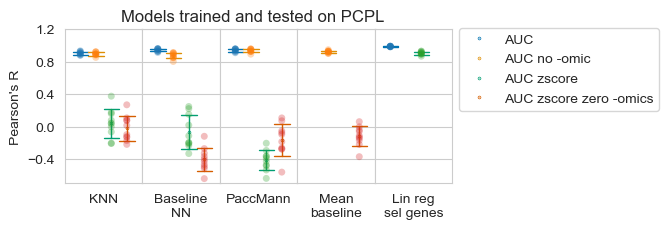

In [13]:
mse_pearson_eval = mse_pearson_eval.replace({'paccmann': 'PaccMann',
                                            'baseline_nn': 'Baseline\nNN', 'mean_baseline': 'Mean\nbaseline',
                                            'lin_reg_feat_sel': 'Lin reg\nsel genes', 'knn': 'KNN',
                                            'AUC_zscore': 'AUC zscore'})
for (dr, g), rows in mse_pearson_eval.groupby(['drug_response', 'genes']):
    if g == 'no RNAseq': mse_pearson_eval.loc[rows.index, 'label'] = dr + ' zero -omics'
    else: mse_pearson_eval.loc[rows.index, 'label'] = dr

models = ['KNN', 'Baseline\nNN', 'PaccMann', 'Mean\nbaseline', 'Lin reg\nsel genes']

solo_pan_rows = mse_pearson_eval[(mse_pearson_eval['mode'] == 'solo_pan')]
solo_pan_rows = solo_pan_rows[solo_pan_rows.model.isin(models)]

plot_and_save(solo_pan_rows, models, 5, (-0.7, 1.2), 'pearson', "Pearson's R", 
              'Models trained and tested on PCPL',
              'figures/results/Pancreatic/Pancreatic_solo_models_pearson.pdf')

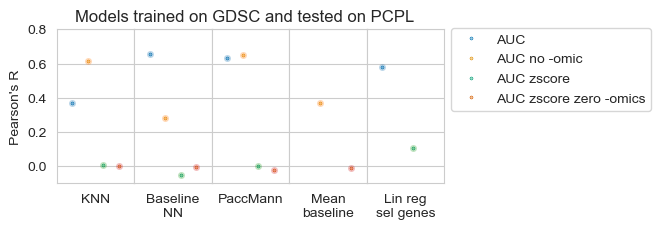

In [14]:
gdsc_pan_rows = mse_pearson_eval[(mse_pearson_eval['mode'] == 'gdsc_pan')]
gdsc_pan_rows = gdsc_pan_rows[gdsc_pan_rows.model.isin(models)]

plot_and_save(gdsc_pan_rows, models, 5, (-0.1, 0.8), 'pearson', "Pearson's R", 
              'Models trained on GDSC and tested on PCPL',
              'figures/results/Pancreatic/Pancreatic_GDSC_models_pearson.pdf')

/var/folders/rp/n5c8n15j53ndhqzy0t3qglcw0000gq/T/ipykernel_44376/1630566369.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'AUC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  else: rel_ranking_res.loc[rows.index, 'label'] = dr


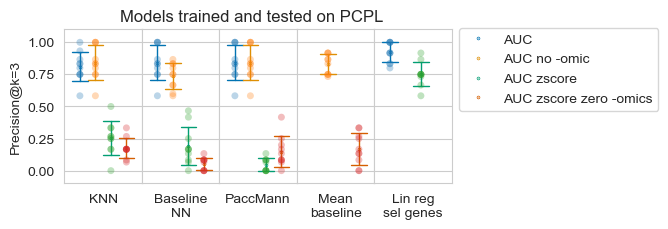

In [15]:
rel_ranking_res = ranking_eval[(ranking_eval.model.isin(['knn', 'mean_baseline', 
                                                        'lin_reg_feat_sel', 'paccmann',
                               'baseline_nn']))]
rel_ranking_res = rel_ranking_res[(rel_ranking_res.model!='lin_reg_feat_sel')|(rel_ranking_res.genes!='PaccMann genes')]
rel_ranking_res = rel_ranking_res.replace({'paccmann': 'PaccMann',
                                            'baseline_nn': 'Baseline\nNN', 'mean_baseline': 'Mean\nbaseline',
                                            'lin_reg_feat_sel': 'Lin reg\nsel genes', 'knn': 'KNN',
                                            'AUC_zscore': 'AUC zscore'})
for (dr, g), rows in rel_ranking_res.groupby(['drug_response', 'genes']):
    if g == 'no RNAseq': rel_ranking_res.loc[rows.index, 'label'] = dr + ' zero -omics'
    else: rel_ranking_res.loc[rows.index, 'label'] = dr

solo_pan_rows = rel_ranking_res[(rel_ranking_res['mode'] == 'solo_pan') & (rel_ranking_res.k == 3)]
solo_pan_rows = solo_pan_rows[solo_pan_rows.model.isin(models)]

plot_and_save(solo_pan_rows, models, 5, (-0.1, 1.1), 'prec', "Precision@k=3", 
              'Models trained and tested on PCPL',
              'figures/results/Pancreatic/Pancreatic_solo_models_ranking_k3.pdf')

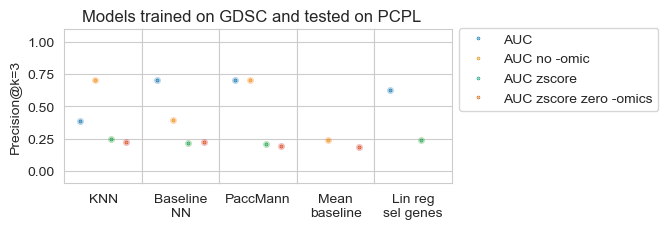

In [16]:
gdsc_pan_rows = rel_ranking_res[(rel_ranking_res['mode'] == 'gdsc_pan') & (rel_ranking_res.k==3)]
gdsc_pan_rows = gdsc_pan_rows[gdsc_pan_rows.model.isin(models)]

plot_and_save(gdsc_pan_rows, models, 5, (-0.1, 1.1), 'prec', "Precision@k=3", 
              'Models trained on GDSC and tested on PCPL',
              'figures/results/Pancreatic/Pancreatic_GDSC_models_ranking_k3.pdf')

In [17]:
counter = 0
mse_pearson_res_per_drug = pd.DataFrame(columns = ['model', 'drug_response', 'genes',
                                           'mse', 'mse_std', 'mse_stderror',
                                           'pearson', 'pearson_std', 'pearson_stderror', 'pval_mean', 'mode'])

for (model, drug_response, genes, mode), rows in mse_pearson_eval_per_drug.groupby(['model', 'drug_response', 'genes', 'mode']):
    mse_pearson_res_per_drug.loc[counter] = [model, drug_response, genes, 
                              np.mean(rows.mse), np.std(rows.mse), np.std(rows.mse)/np.sqrt(len(rows.mse)),
                              np.mean(rows.pearson), np.std(rows.pearson), 
                              np.std(rows.pearson)/np.sqrt(len(rows.pearson)),
                              np.mean(rows.pval), mode
                            ]
    counter+=1
mse_pearson_res_per_drug.to_csv('tables/results/Pancreatic/pancreatic_mse_pearson_per_drug.csv')
mse_pearson_res_per_drug

,model,drug_response,genes,mse,mse_std,mse_stderror,pearson,pearson_std,pearson_stderror,pval_mean,mode
0,baseline_nn,AUC,no RNAseq,0.256529,0.000000,0.000000,NaN,NaN,NaN,NaN,gdsc_pan
1,baseline_nn,AUC,no RNAseq,0.106157,0.017014,0.005380,NaN,NaN,NaN,NaN,solo_pan
2,baseline_nn,AUC,paccmann genes,0.522612,0.000000,0.000000,-0.067461,0.000000,0.000000,0.356361,gdsc_pan
3,baseline_nn,AUC,paccmann genes,0.277259,0.047465,0.015010,0.127427,0.274710,0.086871,0.489841,solo_pan
4,baseline_nn,AUC_zscore,no RNAseq,15.254454,0.000000,0.000000,-0.123251,0.000000,0.000000,0.376888,gdsc_pan
5,baseline_nn,AUC_zscore,no RNAseq,0.996126,0.287655,0.090965,NaN,NaN,NaN,NaN,solo_pan
6,baseline_nn,AUC_zscore,paccmann genes,15.303133,0.000000,0.000000,-0.174039,0.000000,0.000000,0.246635,gdsc_pan
7,baseline_nn,AUC_zscore,paccmann genes,0.972175,0.275425,0.087097,0.005799,0.198623,0.062810,0.492047,solo_pan
8,knn,AUC,no RNAseq,0.046558,0.000000,0.000000,NaN,NaN,NaN,NaN,gdsc_pan
9,knn,AUC,no RNAseq,0.007988,0.002287,0.000723,NaN,NaN,NaN,NaN,solo_pan


/var/folders/rp/n5c8n15j53ndhqzy0t3qglcw0000gq/T/ipykernel_44376/2734851490.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'AUC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  else: rel_ranking_res.loc[rows.index, 'label'] = dr


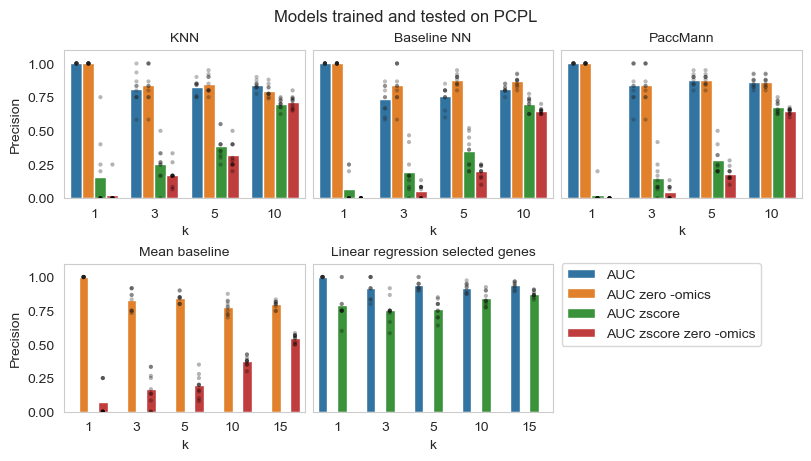

In [18]:
rel_ranking_res = ranking_eval[(ranking_eval.model.isin(['knn', 'mean_baseline', 
                                                        'lin_reg_feat_sel', 'paccmann',
                               'baseline_nn']))]
rel_ranking_res = rel_ranking_res[(rel_ranking_res.model!='lin_reg_feat_sel')|(rel_ranking_res.genes!='PaccMann genes')]
rel_ranking_res = rel_ranking_res.replace({'paccmann': 'PaccMann',
                                                   'baseline_nn': 'Baseline NN', 'mean_baseline': 'Mean baseline',
                                                   'lin_reg_feat_sel': 'Linear regression selected genes', 'knn': 'KNN',
                                                   'AUC_zscore': 'AUC zscore'})
for (dr, g), rows in rel_ranking_res.groupby(['drug_response', 'genes']):
    if g == 'no RNAseq': rel_ranking_res.loc[rows.index, 'label'] = dr + ' zero -omics'
    else: rel_ranking_res.loc[rows.index, 'label'] = dr
 
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,4.5), constrained_layout=True, 
                        sharey=True)
axs = axs.ravel()
X = [1,3,5,10]


for i, model in enumerate(['KNN', 'Baseline NN', 'PaccMann', 'Mean baseline', 'Linear regression selected genes']): 
    if model in ['Mean baseline', 'Linear regression selected genes']: X = ks
    else: X = [1,3,5,10]
    
    X_axis = np.arange(len(X))
    
    data = rel_ranking_res[(rel_ranking_res['mode'] == 'solo_pan') & (rel_ranking_res.model == model)]
    if model == 'Mean baseline':
        append_AUC_df = pd.DataFrame({'k': ks, 'model': [model] * len(ks), 'label': ['AUC']*len(ks),
                                 'prec': [-1]*len(ks)})
        append_AUCzscore_df = pd.DataFrame({'k': ks, 'model': [model] * len(ks), 
                                             'label': ['AUC zscore']*len(ks),
                                             'prec': [-1]*len(ks)})
        data = pd.concat([append_AUC_df, data[data.label=='AUC zero -omics'], append_AUCzscore_df, data[data.label=='AUC zscore zero -omics']])
    elif model == 'Linear regression selected genes':
        append_AUC_no_df = pd.DataFrame({'k': ks, 'model': [model] * len(ks), 'label': ['AUC zero -omics']*len(ks),
                                 'prec': [-1]*len(ks)})
        append_AUCzscore_no_df = pd.DataFrame({'k': ks, 'model': [model] * len(ks), 
                                             'label': ['AUC zscore zero -omics']*len(ks),
                                             'prec': [-1]*len(ks)})
        data = pd.concat([data[data.label=='AUC'], append_AUC_no_df, data[data.label=='AUC zscore'], 
                          append_AUCzscore_no_df])
    
    data = data.sort_values(by='label')
    
    sns.barplot(x="k", y="prec", hue="label", data=data, ax = axs[i], 
            errorbar = None #errorbar = 'sd'
            )
    
    sns.stripplot(x="k", y="prec", hue="label", data=data, ax = axs[i],
              palette='dark:black', jitter = 0, 
              alpha = 0.3, dodge=True, legend=None, size=3)
    
    axs[i].set_title(model, fontsize = 10)
    axs[i].set_xticks(X_axis, X)
    if i==0 or i==3: axs[i].set_ylabel("Precision")
    else: axs[i].set_ylabel(None)
    axs[i].set_xlabel("k")
    axs[i].set_ylim(0,1.1)
    axs[i].grid(False)
    if i==4: axs[i].legend(title=None)
    else: axs[i].get_legend().remove()


handles, labels = axs[4].get_legend_handles_labels()
axs[5].legend(handles, labels, bbox_to_anchor=(0.86, 1.05))
axs[5].axis('off')
axs[4].get_legend().remove()

fig.suptitle('Models trained and tested on PCPL')

plt.savefig('figures/results/Pancreatic/Pancreatic_models_ranking_solo.pdf', facecolor = 'white', transparent = False, dpi=300)

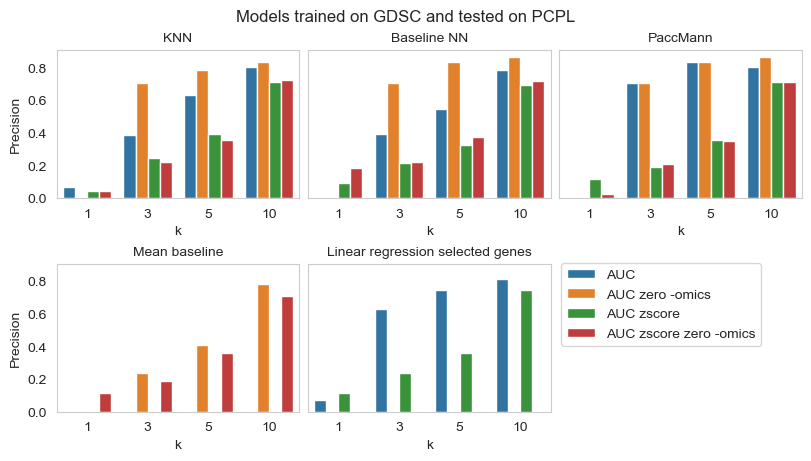

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,4.5), constrained_layout=True, 
                        sharey=True)
axs = axs.ravel()
X = [1,3,5,10]
X_axis = np.arange(len(X))

for i, model in enumerate(['KNN', 'Baseline NN', 'PaccMann', 'Mean baseline', 'Linear regression selected genes']): 
    data = rel_ranking_res[(rel_ranking_res['mode'] == 'gdsc_pan') & (rel_ranking_res.model == model)]
    if model == 'Mean baseline':
        append_AUC_df = pd.DataFrame({'k': X, 'model': [model] * len(X), 'label': ['AUC']*len(X),
                                 'prec': [0.0]*len(X)})
        append_AUCzscore_df = pd.DataFrame({'k': X, 'model': [model] * len(X), 
                                             'label': ['AUC zscore']*len(X),
                                             'prec': [0.0]*len(X)})
        data = pd.concat([append_AUC_df, data[data.label=='AUC zero -omics'], append_AUCzscore_df, data[data.label=='AUC zscore zero -omics']])
    elif model == 'Linear regression selected genes':
        append_AUC_no_df = pd.DataFrame({'k': X, 'model': [model] * len(X), 'label': ['AUC zero -omics']*len(X),
                                 'prec': [0.0]*len(X)})
        append_AUCzscore_no_df = pd.DataFrame({'k': X, 'model': [model] * len(X), 
                                             'label': ['AUC zscore zero -omics']*len(X),
                                             'prec': [0.0]*len(X)})
        data = pd.concat([data[data.label=='AUC'], append_AUC_no_df, data[data.label=='AUC zscore'], append_AUCzscore_no_df])
    
    data = data.sort_values(by='label')
    
    sns.barplot(x="k", y="prec", hue="label", data=data, ax = axs[i], 
            errorbar = None #errorbar = 'sd'
            )
    
    
    axs[i].set_title(model, fontsize = 10)
    axs[i].set_xticks(X_axis, X)
    if i==0 or i==3: axs[i].set_ylabel("Precision")
    else: axs[i].set_ylabel(None)
    axs[i].set_xlabel("k")
    axs[i].grid(False)
    if i==4: axs[i].legend(title=None)
    else: axs[i].get_legend().remove()


handles, labels = axs[0].get_legend_handles_labels()
axs[5].legend(handles, labels, bbox_to_anchor=(0.86, 1.05))
axs[5].axis('off')
axs[4].get_legend().remove()

fig.suptitle('Models trained on GDSC and tested on PCPL')

plt.savefig('figures/results/Pancreatic/pancreatic_models_ranking_with_GDSC.pdf', facecolor = 'white', transparent = False, dpi=300)